In [1]:
import h5py
import numpy as np

SAMPLE_FREQ = 256
SAMPLE_SIZE = SAMPLE_FREQ // 2
WINDOW_POST_RECOVERY = (0, SAMPLE_FREQ * 3)
WINDOW_PRE_RECOVERY = (SAMPLE_FREQ * -7, SAMPLE_FREQ * -1)

def get_samples(dset, window, size):
    curr, stop = window
    end = len(dset)
    if curr < 0:
        curr += end
        stop += end
    while curr < 0:
        curr += size
    
    samples = []
    while end >= curr + size <= stop:
        samples.append(dset[curr:curr + size])
        curr += size
    return samples

def parse_dataset(dset, ref_features):
    columns = dset.attrs['columns']
    for col in columns:
        if col not in ref_features:
            ref_features[col] = len(ref_features)
    features = [ref_features[col] for col in columns]
    
    label = dset.attrs['focus']
    samples = get_samples(dset, WINDOW_POST_RECOVERY if label else WINDOW_PRE_RECOVERY, SAMPLE_SIZE)
    return samples, features, int(label)

def get_data(filepath):
    ref_features = {}
    num_samples = 0

    with h5py.File(filepath) as hf:
        data = [None] * len(hf)
        i = 0
        for dset in hf.values():               
            data[i] = parse_dataset(dset, ref_features)
            num_samples += len(data[i][0])
            i += 1

    num_features = len(ref_features)
    X = np.full((num_samples, SAMPLE_SIZE, num_features), np.nan)
    Y = np.zeros((num_samples, 1))
    
    print('All seen features:', ref_features)
    print('Number of samples in set:', num_samples)

    i = 0
    for samples, features, label in data:
        i_next = i + len(samples)
        if i == i_next:
            continue
        X[i:i_next, :, features] = samples
        Y[i:i_next] = label
        i = i_next
        
    return X.reshape((num_samples, SAMPLE_SIZE * num_features)), Y, num_features

In [2]:
X, Y, NUM_FEATURES = get_data('../data/epochs/1572178629-1577962907.h5')
NUM_SAMPLES = 6

All seen features: {'EEG_TP9': 0, 'EEG_AF7': 1, 'EEG_AF8': 2, 'EEG_TP10': 3, 'EEG_Right_AUX': 4, 'ACC_X': 5, 'ACC_Y': 6, 'ACC_Z': 7, 'GYRO_X': 8, 'GYRO_Y': 9, 'GYRO_Z': 10, 'PPG_PPG1': 11, 'PPG_PPG2': 12, 'PPG_PPG3': 13}
Number of samples in set: 15648


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, BatchNormalization, Conv1D

def add_ic_layer(model, name, dropout=0.2):
    model.add(BatchNormalization(name=f"{name}_bn"))
    if dropout:
        model.add(Dropout(dropout, name=f"{name}_dropout"))

def add_lstm_layer(model, name, params):
    ic_params = params.pop("ic_params", {})
    model.add(LSTM(name=name, **params))
    add_ic_layer(model, name, **ic_params)
    
def get_lstm_model(
    input_shape,
    lstm_layers,
    conv1d_params=None,
    dense_units=30,
    dense_dropout=0.2,
):
    model = Sequential()
    
    if conv1d_params is not None:
        name = "conv1d"
        model.add(Conv1D(name=name, input_shape=input_shape, **conv1d_params))
        model.add(Activation("relu", name=f"{name}_relu"))
        add_ic_layer(model, name)
    
    num_lstm_layers = len(lstm_layers)
    for i in range(num_lstm_layers):
        name = f"lstm_{i + 1}"
        params = lstm_layers[i]
        if i == 0 and conv1d_params is None:
            params["input_shape"] = input_shape
        if i < num_lstm_layers - 1:
            params["return_sequences"] = True
        add_lstm_layer(model, name, params)
    
    name = "dense"
    model.add(Dense(dense_units, activation="relu", name=name))
    add_ic_layer(model, name, dense_dropout)
    
    model.add(Dense(1, activation='sigmoid', name="output"))
    
    return model

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 128)            983552    
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 6, 128)            512       
_________________________________________________________________
lstm_1_dropout (Dropout)     (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
lstm_2_bn (BatchNormalizatio (None, 128)               512       
_________________________________________________________________
lstm_2_dropout (Dropout)     (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 30)               

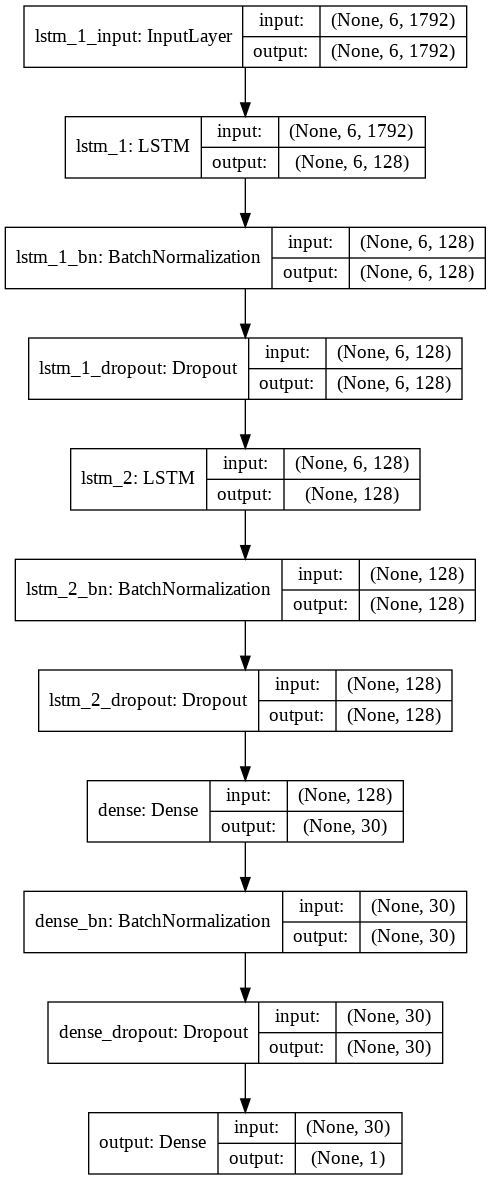

In [4]:
from keras.utils import plot_model

model_one = get_lstm_model(
    (NUM_SAMPLES, NUM_FEATURES * SAMPLE_SIZE),
    [
        { "units": 128, "dropout": 0.2, "ic_params": { "dropout": 0.2 } },
        { "units": 128, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params=None,
)
model_one.summary()
plot_model(model_one, to_file='model_one.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 189, 196)          41356     
_________________________________________________________________
conv1d_relu (Activation)     (None, 189, 196)          0         
_________________________________________________________________
conv1d_bn (BatchNormalizatio (None, 189, 196)          784       
_________________________________________________________________
conv1d_dropout (Dropout)     (None, 189, 196)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 189, 128)          166400    
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 189, 128)          512       
_________________________________________________________________
lstm_1_dropout (Dropout)     (None, 189, 128)         

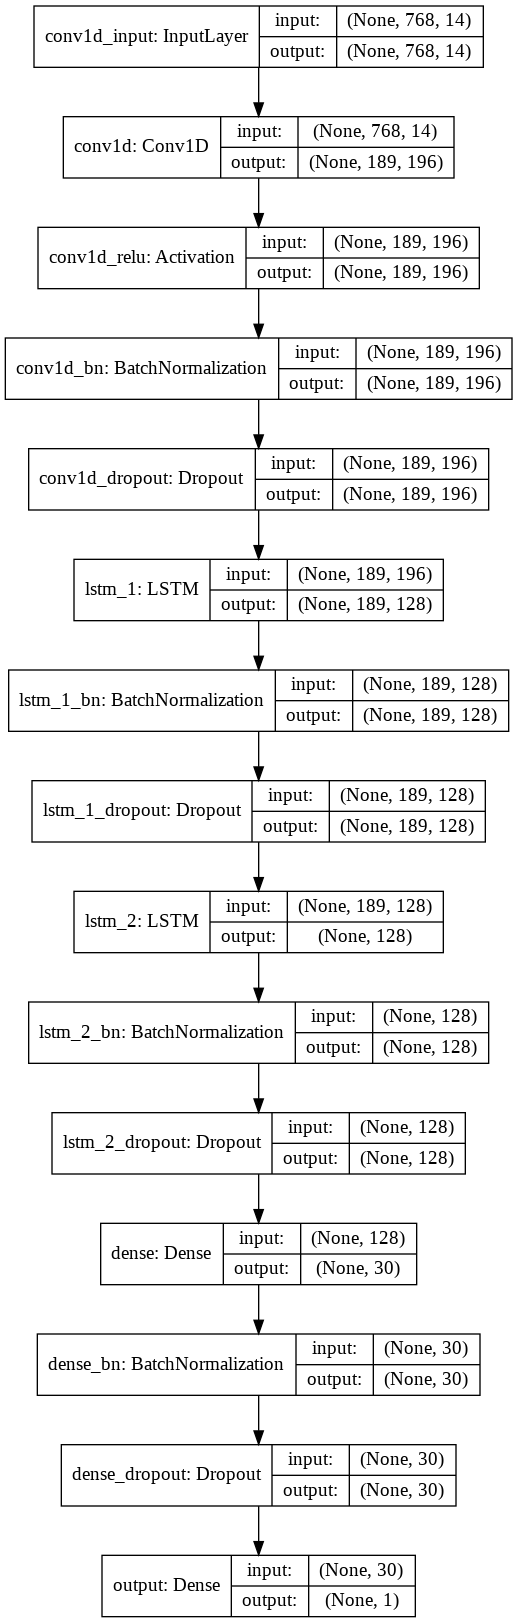

In [5]:
from keras.utils import plot_model

model_two = get_lstm_model(
    (NUM_SAMPLES * SAMPLE_SIZE, NUM_FEATURES),
    [
        { "units": 128, "dropout": 0, "ic_params": { "dropout": 0.2 } },
        { "units": 128, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params={"filters": 196, "kernel_size": 15, "strides": 4},
)
model_two.summary()
plot_model(model_two, to_file='model_two.png', show_shapes=True, show_layer_names=True)

In [6]:
from keras.optimizers import Adam

def compile_model(
    model,
    learning_rate=0.01,
    beta_one=0.9,
    beta_two=0.999,
    decay=0.01,
):
    opt = Adam(learning_rate, beta_one, beta_two, decay)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
LEARNING_RATE=0.1
BETA_ONE=0.9
BETA_TWO=0.999
DECAY=0.01
compile_model(model_one, LEARNING_RATE, BETA_ONE, BETA_TWO, DECAY)
compile_model(model_two, LEARNING_RATE, BETA_ONE, BETA_TWO, DECAY)